In [ ]:
!pip install -q ultralytics
!pip install -q transformers
!pip install -q simple-lama-inpainting
!pip install -q segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 MB 52.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 42.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from ultralytics import YOLO
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from simple_lama_inpainting import SimpleLama

import segmentation_models_pytorch as smp
import glob
from PIL import Image

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# ==========================
# 0. Config
# ==========================
PROJECT_ROOT = "/content/drive/MyDrive/loid_cityscapes"  # 필요하면 수정a
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_SIZE = (1024, 2048)  # (H, W)

os.makedirs(f"{PROJECT_ROOT}/experiments/figs", exist_ok=True)
os.makedirs(f"{PROJECT_ROOT}/results", exist_ok=True)

In [ ]:
# ==========================
# 1. Baseline Segmentation (Day 1)
# ==========================
print("=== Day 1: Baseline Segmentation ===")

# -----------------------------
# LaneSegmentationModel 정의
# -----------------------------
class LaneSegmentationModel(nn.Module):
    """DeepLabV3+ 기반 차선/도로 세그멘테이션 모델"""

    def __init__(self, num_classes=1, encoder="resnet34"):
        super().__init__()
        self.model = smp.DeepLabV3Plus(
            encoder_name=encoder,
            encoder_weights="imagenet",
            classes=num_classes,
            activation=None  # BCEWithLogitsLoss에서 activation 처리
        )

    def forward(self, x):
        """
        x: [B, 3, H, W]
        return: [B, H, W] logits
        """
        logits = self.model(x)         # [B, 1, H, W]
        return logits.squeeze(1)       # [B, H, W]



# 01_cityscapes_seg_baseline.ipynb 에서 학습한 모델 경로
baseline_ckpt = f"{PROJECT_ROOT}/experiments/ckpts/baseline_seg.pth"
state_dict = torch.load(baseline_ckpt, map_location=DEVICE)
baseline_model = LaneSegmentationModel(num_classes=1, encoder="resnet34").to(DEVICE)
baseline_model.load_state_dict(state_dict)
baseline_model.eval()
print("✅ Baseline model loaded")


def seg_baseline(img_np, model, device=DEVICE):
    """
    Baseline road segmentation
    img_np: (H, W, 3) uint8, RGB
    return: (H, W) float32, [0,1]
    """
    H, W = img_np.shape[:2]
    img_resized = cv2.resize(img_np, (512, 1024))  # 예: (H=512, W=1024)
    img_tensor = torch.from_numpy(img_resized.transpose(2, 0, 1)).float() / 255.0
    img_tensor = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(img_tensor)
        probs = torch.sigmoid(logits).squeeze(0).cpu().numpy()  # (h,w)

    road_prob = cv2.resize(probs, (W, H))
    return road_prob


# class CityscapesDataset(Dataset):
#     def __init__(self, root_dir, split='val', img_size=(1024, 2048)):
#         self.root_dir = root_dir
#         self.split = split
#         self.img_size = img_size
#         self.image_list = self._load_image_list()

#     def _load_image_list(self):
#         img_dir = os.path.join(self.root_dir, "leftImg8bit", self.split)
#         images = []
#         for city in sorted(os.listdir(img_dir)):
#             city_path = os.path.join(img_dir, city)
#             for img_name in sorted(os.listdir(city_path)):
#                 images.append(os.path.join(city_path, img_name))
#         return images

#     def __len__(self):
#         return len(self.image_list)

#     def __getitem__(self, idx):
#         img_path = self.image_list[idx]
#         img = cv2.imread(img_path)[:, :, ::-1]  # BGR -> RGB
#         img = cv2.resize(img, self.img_size)
#         img_tensor = torch.from_numpy(img.transpose(2, 0, 1)).float() / 255.0
#         return {"image": img_tensor, "path": img_path}

class CityscapesDataset(Dataset):
    """Cityscapes 도로/차선 세그멘테이션 데이터셋"""

    def __init__(self, root, split="train", transform=None):
        self.root = root
        self.split = split
        self.transform = transform

        # 이미지/라벨 경로
        img_dir = os.path.join(root, "leftImg8bit", split)
        gt_dir = os.path.join(root, "gtFine", split)

        # 파일 찾기
        all_img_paths = sorted(glob.glob(f"{img_dir}/*/*.png"))
        all_gt_paths = sorted(glob.glob(f"{gt_dir}/*/*_gtFine_labelIds.png"))

        print(f"🔍 총 이미지: {len(all_img_paths)}장")
        print(f"🔍 총 GT: {len(all_gt_paths)}장")

        # 파일명 매칭
        self.img_paths = []
        self.gt_paths = []

        img_basenames = {os.path.basename(p) for p in all_img_paths}
        gt_basenames = {os.path.basename(p) for p in all_gt_paths}

        matched_count = 0
        for img_path in all_img_paths:
            img_name = os.path.basename(img_path)
            gt_name = img_name.replace("_leftImg8bit.png", "_gtFine_labelIds.png")

            if gt_name in gt_basenames:
                city_folder = os.path.basename(os.path.dirname(img_path))
                gt_path = os.path.join(gt_dir, city_folder, gt_name)
                self.img_paths.append(img_path)
                self.gt_paths.append(gt_path)
                matched_count += 1

        print(f"✅ 매칭된 쌍: {matched_count}개")

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        CITYSCAPES_ROAD_IDS = {7, 8, 9, 10}
        # 안전한 PIL → numpy 변환
        img_pil = Image.open(self.img_paths[idx]).convert("RGB")
        img = np.asarray(img_pil).astype(np.float32) / 255.0  # [H,W,C] 0~1

        labelids_pil = Image.open(self.gt_paths[idx])
        labelids = np.asarray(labelids_pil).astype(np.uint8)  # [H,W]

        # Road proxy GT 생성
        lane_gt = np.isin(labelids, list(CITYSCAPES_ROAD_IDS)).astype(np.float32)

        # 변환 적용
        if self.transform:
            augmented = self.transform(image=(img * 255).astype(np.uint8), mask=(lane_gt * 255).astype(np.uint8))
            img = augmented['image'].astype(np.float32) / 255.0
            lane_gt = augmented['mask'].astype(np.float32) / 255.0

        # 텐서 변환 (torch.tensor 사용)
        img_tensor = torch.tensor(img.transpose(2, 0, 1), dtype=torch.float32)  # [C,H,W]
        gt_tensor = torch.tensor(lane_gt, dtype=torch.float32)  # [H,W]

        return {
            "image": img_tensor,
            "lane_gt": gt_tensor,
            "img_path": self.img_paths[idx]
        }


val_dataset = CityscapesDataset(f"{PROJECT_ROOT}/datasets", split="val")
print(f"✅ Validation dataset: {len(val_dataset)} images")

=== Day 1: Baseline Segmentation ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

✅ Baseline model loaded
🔍 총 이미지: 500장
🔍 총 GT: 500장
✅ 매칭된 쌍: 500개
✅ Validation dataset: 500 images


In [ ]:
# ==========================
# 2. Occlusion Detection (Day 2, YOLO)
# ==========================
print("\n=== Day 2: Occlusion Detection (YOLO) ===")

detector = YOLO("yolov8m.pt")
detector.to(DEVICE)

TARGET_CLASS_IDS = [0, 1, 2, 3, 5, 7]

def get_occlusion_mask(img_tensor, detector, device=DEVICE, conf_thres=0.25):
    H, W = img_tensor.shape[1:]
    img_np = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

    # YOLO는 numpy를 BGR로 본다고 가정하니, Cityscapes RGB라면 BGR로 바꿔주는 게 더 안전
    img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

    results = detector(img_bgr, conf=conf_thres, verbose=False)
    occlusion_mask = np.zeros((H, W), dtype=np.float32)

    if results[0].boxes is not None:
        for box in results[0].boxes:
            cls_id = int(box.cls.item())
            conf = float(box.conf.item())
            if cls_id in TARGET_CLASS_IDS:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                x1, y1 = max(0, x1), max(0, y1)
                x2, y2 = min(W, x2), min(H, y2)
                occlusion_mask[y1:y2, x1:x2] = 1.0

    return occlusion_mask


print("✅ YOLOv8m loaded")


=== Day 2: Occlusion Detection (YOLO) ===
✅ YOLOv8m loaded


Occlusion ratio: 0.072164536


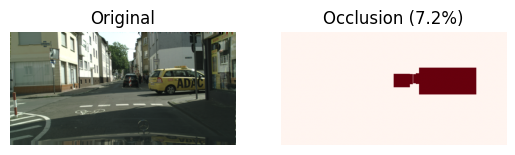

In [ ]:
sample = val_dataset[0]
img_tensor = sample['image']
img_np = (img_tensor.permute(1,2,0).cpu().numpy() * 255).astype(np.uint8)

occl = get_occlusion_mask(img_tensor, detector, device=DEVICE)
print("Occlusion ratio:", occl.mean())

plt.subplot(1,2,1); plt.imshow(img_np); plt.title("Original"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(occl, cmap='Reds'); plt.title(f"Occlusion ({occl.mean():.1%})"); plt.axis('off')
plt.show()


In [ ]:
# ============================================================
# 셀 5: Day 3 - LaMa Inpainting (수정)
# ============================================================

# LaMa 초기화
inpainter = SimpleLama()

def inpaint(img_np, mask_np, inpainter, device=DEVICE):
    """LaMa로 occlusion 영역 inpaint

    Args:
        img_np: (H, W, 3) uint8 numpy array
        mask_np: (H, W) uint8 or float numpy array
        inpainter: SimpleLama instance

    Returns:
        inpainted: (H, W, 3) uint8 numpy array
    """
    # mask 정규화
    if isinstance(mask_np, np.ndarray):
        if mask_np.dtype == np.uint8:
            mask_np = mask_np.astype(np.float32) / 255.0
        else:
            mask_np = mask_np.astype(np.float32)

    # SimpleLama 적용
    inpainted_pil = inpainter(img_np, mask_np)

    # PIL Image → numpy array 변환
    if hasattr(inpainted_pil, 'convert'):  # PIL Image 인지 확인
        inpainted = np.array(inpainted_pil.convert('RGB'), dtype=np.uint8)
    else:
        inpainted = inpainted_pil  # 이미 numpy면 그대로

    return inpainted

print("✅ Day 3: LaMa Inpainting Ready")


Downloading: "https://github.com/enesmsahin/simple-lama-inpainting/releases/download/v0.1.0/big-lama.pt" to /root/.cache/torch/hub/checkpoints/big-lama.pt
100%|██████████| 196M/196M [00:08<00:00, 23.0MB/s]


✅ Day 3: LaMa Inpainting Ready


In [ ]:
# # ==========================
# # 4. SegFormer Road / Drivable Seg (Day 4)
# # ==========================
# print("\n=== Day 4: SegFormer Road/Drivable Segmentation ===")

# MODEL_NAME = "nvidia/segformer-b0-finetuned-cityscapes-1024-1024"


# class CityscapesSegFormer:
#     def __init__(self, model_name=MODEL_NAME, device="cuda"):
#         self.device = torch.device(device if torch.cuda.is_available() else "cpu")
#         self.processor = SegformerImageProcessor.from_pretrained(model_name)
#         self.model = SegformerForSemanticSegmentation.from_pretrained(model_name)
#         self.model.to(self.device).eval()
#         # Cityscapes: road(7), sidewalk(8), parking(9)
#         self.drivable_ids = [7, 8, 9]

#     def segment_drivable(self, img_np, conf_thres=0.3):
#         """
#         img_np: (H,W,3) uint8 RGB
#         return:
#             drivable_mask: (H,W) uint8 0/1
#             drivable_prob: (H,W) float
#         """
#         inputs = self.processor(images=img_np, return_tensors="pt").to(self.device)
#         with torch.no_grad():
#             outputs = self.model(**inputs)
#             logits = outputs.logits  # (1,C,h,w)

#         upsampled = F.interpolate(
#             logits, size=img_np.shape[:2], mode="bilinear", align_corners=False
#         )
#         probs = F.softmax(upsampled, dim=1)[0].cpu().numpy()  # (C,H,W)

#         drivable_prob = probs[self.drivable_ids].sum(axis=0)
#         drivable_mask = (drivable_prob > conf_thres).astype(np.uint8)

#         return drivable_mask, drivable_prob


# segformer_model = CityscapesSegFormer(device=DEVICE)
# print("✅ SegFormer loaded")

## 📌 **셀 6: Day 4 - SegFormer Road Segmentation**

MODEL_NAME = "nvidia/segformer-b0-finetuned-cityscapes-1024-1024"

class CityscapesSegFormer:
    def __init__(self, model_name=MODEL_NAME, device='cuda'):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        print(f"Loading {model_name}...")
        self.processor = SegformerImageProcessor.from_pretrained(model_name)
        self.model = SegformerForSemanticSegmentation.from_pretrained(model_name)
        self.model.to(self.device).eval()

    def segment_drivable(self, img_np, conf_thres=0.3):
        """도로 segmentation (Cityscapes class 0 = road)"""
        from PIL import Image

        H, W = img_np.shape[:2]

        # numpy → PIL Image
        if isinstance(img_np, np.ndarray):
            image_rgb = Image.fromarray(img_np.astype('uint8')).convert("RGB")
        else:
            image_rgb = img_np.convert("RGB")

        # SegFormer 추론
        inputs = self.processor(images=image_rgb, return_tensors="pt").to(self.device)

        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits  # (1, 19, H/4, W/4)

        # 원본 해상도로 복원
        upsampled_logits = F.interpolate(
            logits,
            size=(H, W),
            mode='bilinear',
            align_corners=False
        )

        # argmax로 각 픽셀의 class ID 추출
        pred_seg = upsampled_logits.argmax(dim=1)[0].detach().cpu().numpy()  # (H, W)

        # 확률맵: road class의 softmax 확률
        probs = F.softmax(upsampled_logits, dim=1)[0].cpu().numpy()  # (19, H, W)
        drivable_prob = probs[0]  # class 0 (road)의 확률

        # Cityscapes: class 0 = road (ID=0) + threshold 적용 ✅
        drivable_mask = ((pred_seg == 0) & (drivable_prob > conf_thres)).astype(np.uint8)

        return drivable_mask, drivable_prob

segformer_model = CityscapesSegFormer(device=DEVICE)
print("✅ Day 4: SegFormer Ready (Cityscapes class 0 = Road)")


Loading nvidia/segformer-b0-finetuned-cityscapes-1024-1024...


preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

✅ Day 4: SegFormer Ready (Cityscapes class 0 = Road)


In [ ]:
from collections import OrderedDict
# 1. 커스텀 모델 구조 정의 (예: Unet)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LaneSegmentationModel(nn.Module):
    """DeepLabV3+ 기반 차선/도로 세그멘테이션 모델"""

    def __init__(self, num_classes=1, encoder="resnet34"):
        super().__init__()
        self.model = smp.DeepLabV3Plus(
            encoder_name=encoder,
            encoder_weights="imagenet",
            classes=num_classes,
            activation=None  # BCEWithLogitsLoss에서 activation 처리
        )

    def forward(self, x):
        """Forward pass

        Args:
            x: [B, 3, H, W] 이미지

        Returns:
            logits: [B, 1, H, W] 또는 probs: [B, H, W]
        """
        logits = self.model(x)  # [B, 1, H, W]
        return logits.squeeze(1)  # [B, H, W]

# 2. .pth 파일 로드
model_path = "/content/drive/MyDrive/loid_cityscapes/experiments/ckpts/baseline_seg.pth" # 실제 파일 경로 입력

# 가중치 불러오기
checkpoint = torch.load(model_path, map_location=device)

preprocess_c = smp.encoders.get_preprocessing_fn('resnet34', pretrained='imagenet')
model_custom = LaneSegmentationModel(num_classes=1, encoder="resnet34").to(device)

# 가중치 로드 (baseline_seg.pth)
checkpoint = torch.load(model_path, map_location=device)
model_custom.load_state_dict(checkpoint, strict=False)
model_custom.eval() # 평가 모드 전환


LaneSegmentationModel(
  (model): DeepLabV3Plus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [ ]:
#result 일부만 뽑기 (아래 cell에서 전체 test)

results_complete = []

print("\n" + "="*70)
print("🚗 COMPLETE PIPELINE: Day 1-4")
print("="*70)

# ⚙️ 샘플 개수 조절 (여기서 변경!)
N_SAMPLES = 5  # 👈 5, 10, 20 등으로 자유롭게 변경 가능
# N_SAMPLES = min(20, len(val_dataset))  # 전체 20개 테스트할 때는 이 라인 사용

print(f"🎯 Testing {N_SAMPLES} samples out of {len(val_dataset)} total\n")

pbar = tqdm(range(N_SAMPLES), desc="Complete Pipeline")

for sample_idx in pbar:
    sample = val_dataset[sample_idx]
    img_tensor = sample['image']
    H, W = img_tensor.shape[1:]
    img_np = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

    # ========== Day 1: Baseline ==========
    road_orig = seg_baseline(img_np, baseline_model, device=DEVICE)

    # ========== Day 2: Occlusion Detection ==========
    occlusion_mask = get_occlusion_mask(img_tensor, detector, device=DEVICE)
    occlusion_mask_np = (occlusion_mask * 255).astype(np.uint8)

    # ========== Day 3: LaMa Inpainting ==========
    t_lama = time.time()
    inpainted_img = inpaint(img_np, occlusion_mask_np, inpainter)
    lama_time = (time.time() - t_lama) * 1000

    # Day 1 on inpainted image
    road_lama = seg_baseline(inpainted_img, baseline_model, device=DEVICE)

    # ========== Day 4: SegFormer ==========
    t_sf = time.time()
    drivable_mask, drivable_prob = segformer_model.segment_drivable(inpainted_img)
    sf_time = (time.time() - t_sf) * 1000

    # ========== 메트릭 저장 ==========
    results_complete.append({
        'idx': sample_idx,
        'road_baseline': float(road_orig.mean()),
        'road_baseline_lama': float(road_lama.mean()),
        'occlusion_ratio': float(occlusion_mask.mean()),
        'inpaint_improvement': float(road_lama.mean() - road_orig.mean()),
        'drivable_area': float(drivable_mask.mean()),
        'drivable_prob_mean': float(drivable_prob.mean()),
        'lama_ms': lama_time,
        'sf_ms': sf_time,
        'total_ms': lama_time + sf_time
    })

    pbar.set_postfix({
        'Road': f"{road_lama.mean():.2f}",
        'Drv': f"{drivable_mask.mean():.1%}",
        'T': f"{lama_time+sf_time:.0f}ms"
    })

df_complete = pd.DataFrame(results_complete)
print("\n✅ Pipeline 완료!")



🚗 COMPLETE PIPELINE: Day 1-4
🎯 Testing 500 samples out of 500 total



Complete Pipeline:   0%|          | 0/500 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/14.9M [00:00<?, ?B/s]

Complete Pipeline: 100%|██████████| 500/500 [08:02<00:00,  1.04it/s, Road=0.31, Drv=28.2%, T=375ms]


✅ Pipeline 완료!


In [ ]:
# ==========================
# 5. Pipeline 실행 (Day 1~4 통합)
# ==========================
print("\n=== Running Complete Pipeline (Day 1~4) ===")

results_complete = []

pbar = tqdm(range(len(val_dataset)), desc="Complete Pipeline")
for idx in pbar:
    sample = val_dataset[idx]
    img_tensor = sample["image"]  # (3,H,W)
    img_np = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

    # ----- Day 1: baseline on original -----
    road_orig = seg_baseline(img_np, baseline_model, device=DEVICE)

    # ----- Day 2: occlusion detection -----
    occl_mask = get_occlusion_mask(img_tensor, detector, device=DEVICE)
    occl_np = (occl_mask * 255).astype(np.uint8)

    # ----- Day 3: LaMa inpainting -----
    t_lama = time.time()
    inpainted_img = inpaint(img_np, occl_np, inpainter)
    lama_ms = (time.time() - t_lama) * 1000

    # baseline on inpainted
    road_lama = seg_baseline(inpainted_img, baseline_model, device=DEVICE)

    # ----- Day 4: SegFormer -----
    t_sf = time.time()
    drv_mask, drv_prob = segformer_model.segment_drivable(inpainted_img, conf_thres=0.3)
    sf_ms = (time.time() - t_sf) * 1000

    results_complete.append(
        {
            "idx": idx,
            "road_baseline": float(road_orig.mean()),
            "road_baseline_lama": float(road_lama.mean()),
            "occlusion_ratio": float(occl_mask.mean()),
            "inpaint_improvement": float(road_lama.mean() - road_orig.mean()),
            "lama_ms": lama_ms,
            "drivable_area": float(drv_mask.mean()),
            "drivable_prob_mean": float(drv_prob.mean()),
            "sf_ms": sf_ms,
            "total_ms": lama_ms + sf_ms,
        }
    )

    pbar.set_postfix(
        {
            "Road": f"{road_lama.mean():.3f}",
            "Drv": f"{drv_mask.mean():.1%}",
            "T": f"{(lama_ms+sf_ms):.0f}ms",
        }
    )

df_complete = pd.DataFrame(results_complete)
print("\n=== 📊 Summary ===")
print(df_complete.round(3).describe())



=== Running Complete Pipeline (Day 1~4) ===


Complete Pipeline: 100%|██████████| 500/500 [04:38<00:00,  1.80it/s, Road=0.306, Drv=28.2%, T=374ms]


=== 📊 Summary ===
              idx  road_baseline  road_baseline_lama  occlusion_ratio  \
count  500.000000     500.000000          500.000000       500.000000   
mean   249.500000       0.340038            0.352810         0.107704   
std    144.481833       0.071108            0.068744         0.082530   
min      0.000000       0.150000            0.149000         0.000000   
25%    124.750000       0.296750            0.316750         0.045000   
50%    249.500000       0.347000            0.358000         0.086500   
75%    374.250000       0.392000            0.402250         0.155000   
max    499.000000       0.492000            0.499000         0.443000   

       inpaint_improvement     lama_ms  drivable_area  drivable_prob_mean  \
count           500.000000  500.000000     500.000000          500.000000   
mean              0.012780  207.072224       0.428852            0.426424   
std               0.017729    6.250818       0.065417            0.065129   
min            

In [ ]:
# ==========================
# 6. 지표 출력
# ==========================
print("\n🎯 주요 지표:")
print(f"평균 Baseline Road: {df_complete['road_baseline'].mean():.3f}")
print(
    f"평균 LaMa 이후 Road: {df_complete['road_baseline_lama'].mean():.3f} "
    f"(Δ {df_complete['inpaint_improvement'].mean():+.3f})"
)
print(f"평균 Occlusion: {df_complete['occlusion_ratio'].mean():.1%}")
print(f"평균 Drivable Area: {df_complete['drivable_area'].mean():.1%}")

print("\n⏱️  시간:")
print(f"LaMa: {df_complete['lama_ms'].mean():.0f} ms")
print(f"SegFormer: {df_complete['sf_ms'].mean():.0f} ms")
print(f"Total: {df_complete['total_ms'].mean():.0f} ms/frame")
print(f"FPS: {1000/df_complete['total_ms'].mean():.1f}")


🎯 주요 지표:
평균 Baseline Road: 0.340
평균 LaMa 이후 Road: 0.353 (Δ +0.013)
평균 Occlusion: 10.8%
평균 Drivable Area: 42.9%

⏱️  시간:
LaMa: 207 ms
SegFormer: 168 ms
Total: 375 ms/frame
FPS: 2.7



=== Visualizing sample ===


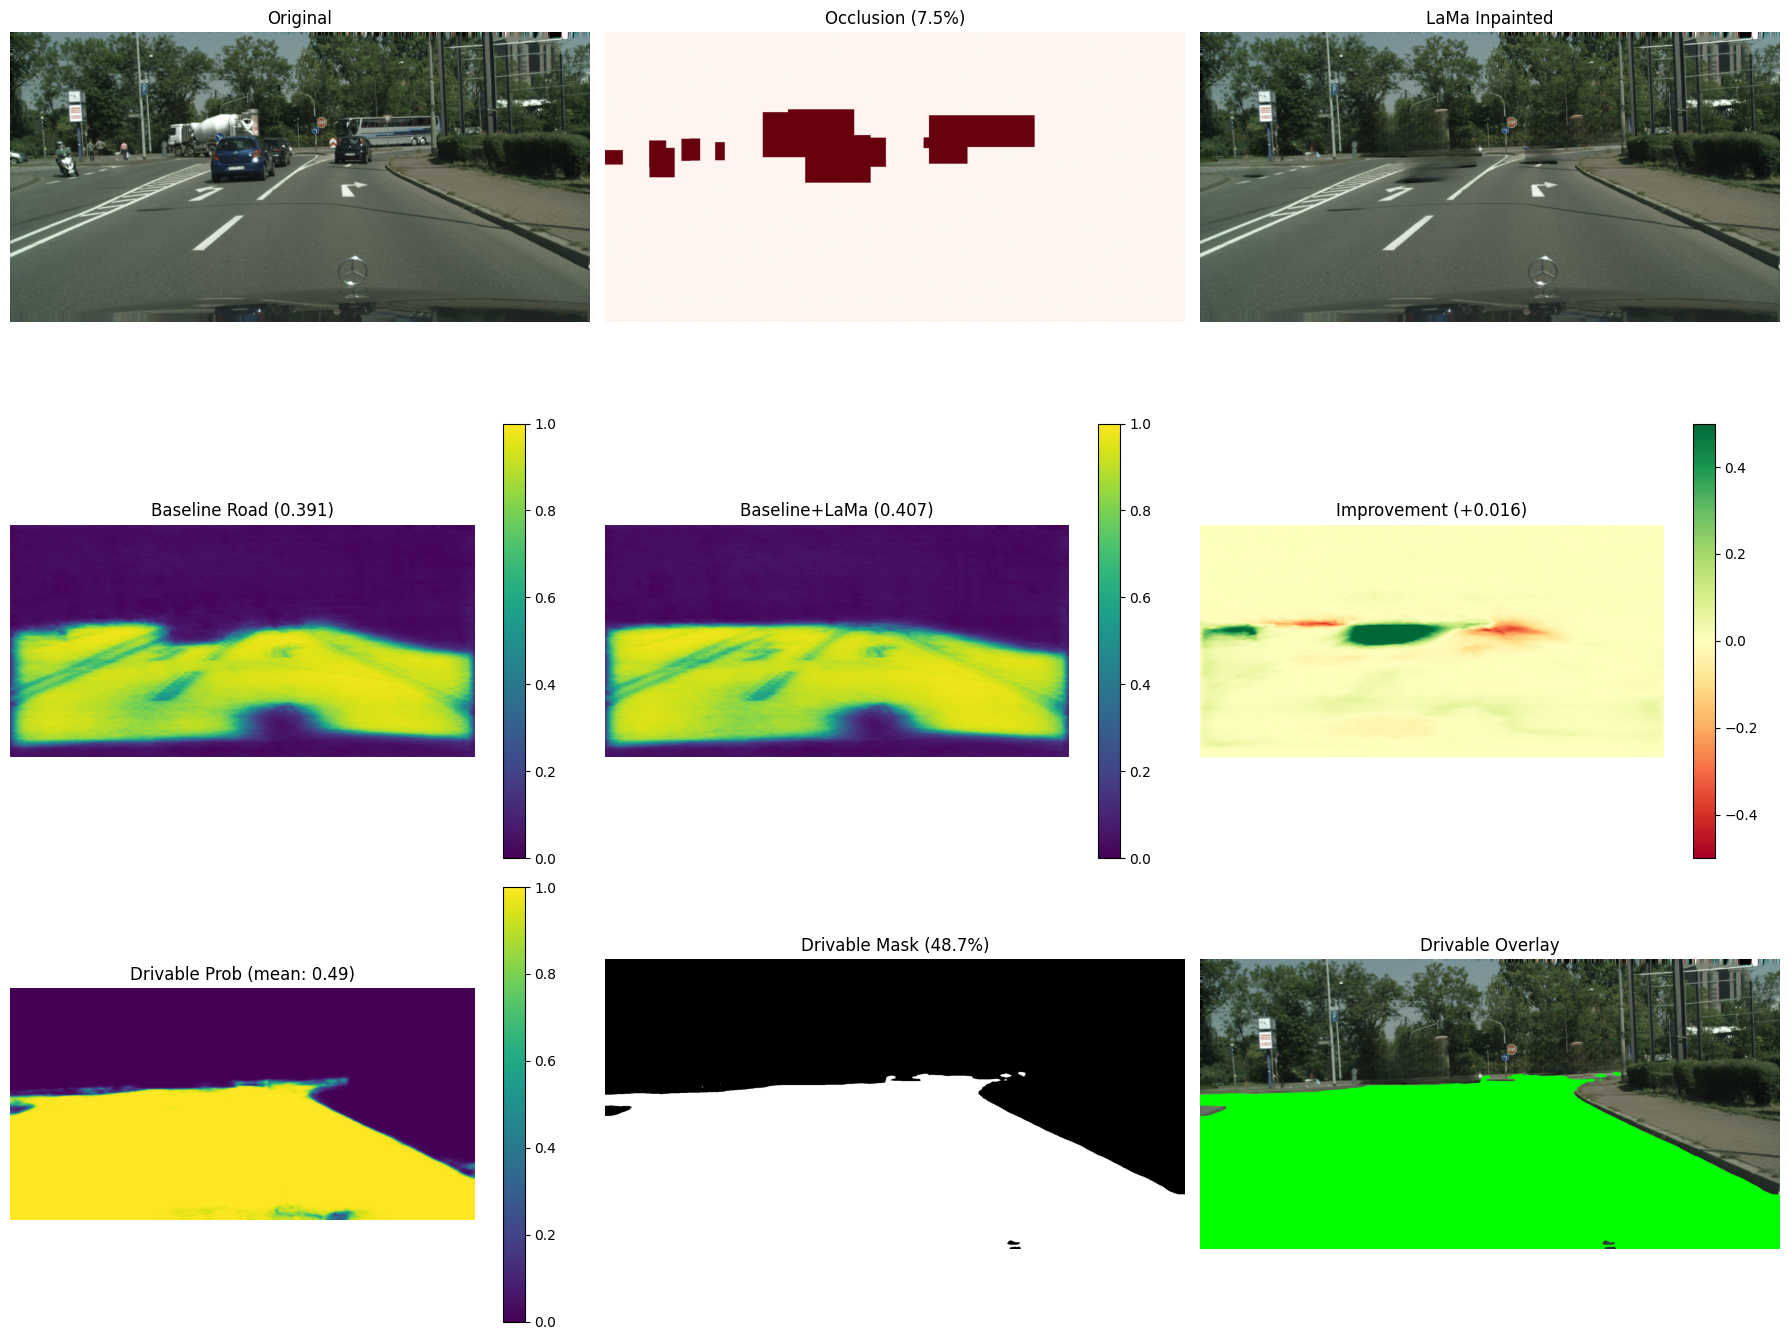

In [ ]:
# ==========================
# 7. 첫 샘플 시각화
# ==========================
print("\n=== Visualizing sample ===")

sample = val_dataset[12] # <--- 번호 바꿔서 다른 샘플 관측 가능
img_tensor = sample["image"]
img_np = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

occl_mask = get_occlusion_mask(img_tensor, detector, device=DEVICE)
occl_np = (occl_mask * 255).astype(np.uint8)
inpainted = inpaint(img_np, occl_np, inpainter)
road_orig = seg_baseline(img_np, baseline_model, device=DEVICE)
road_lama = seg_baseline(inpainted, baseline_model, device=DEVICE)
drv_mask, drv_prob = segformer_model.segment_drivable(inpainted, conf_thres=0.3)

fig, axes = plt.subplots(3, 3, figsize=(18, 14))

# Row 1
axes[0, 0].imshow(img_np)
axes[0, 0].set_title("Original")
axes[0, 1].imshow(occl_np, cmap="Reds")
axes[0, 1].set_title(f"Occlusion ({occl_mask.mean():.1%})")
axes[0, 2].imshow(inpainted)
axes[0, 2].set_title("LaMa Inpainted")

# Row 2
im1 = axes[1, 0].imshow(road_orig, cmap="viridis", vmin=0, vmax=1)
axes[1, 0].set_title(f"Baseline Road ({road_orig.mean():.3f})")
plt.colorbar(im1, ax=axes[1, 0])

im2 = axes[1, 1].imshow(road_lama, cmap="viridis", vmin=0, vmax=1)
axes[1, 1].set_title(f"Baseline+LaMa ({road_lama.mean():.3f})")
plt.colorbar(im2, ax=axes[1, 1])

improvement = road_lama - road_orig
im3 = axes[1, 2].imshow(improvement, cmap="RdYlGn", vmin=-0.5, vmax=0.5)
axes[1, 2].set_title(f"Improvement ({improvement.mean():+.3f})")
plt.colorbar(im3, ax=axes[1, 2])

# Row 3
im4 = axes[2, 0].imshow(drv_prob, cmap="viridis", vmin=0, vmax=1)
axes[2, 0].set_title(f"Drivable Prob (mean: {drv_prob.mean():.2f})")
plt.colorbar(im4, ax=axes[2, 0])

axes[2, 1].imshow(drv_mask * 255, cmap="gray")
axes[2, 1].set_title(f"Drivable Mask ({drv_mask.mean():.1%})")

overlay = inpainted.copy()
overlay[drv_mask == 1] = [0, 255, 0]
axes[2, 2].imshow(overlay)
axes[2, 2].set_title("Drivable Overlay")

for ax in axes.flat:
    ax.axis("off")

plt.tight_layout()
plt.savefig(
    f"{PROJECT_ROOT}/experiments/figs/complete_pipeline_demo.png",
    dpi=150,
    bbox_inches="tight",
)
plt.show()


# Dataset

In [ ]:
!pip install -q roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 65.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
simple-lama-inpainting 0.1.2 requires pillow<10.0.0,>=9.5.0, but you have pillow 12.1.0 which is incompatible.
gradio 5.50.0 requires pillow<12.0,>=8.0, but you have pillow 12.1.0 which is incompatible.


In [ ]:
import json

In [ ]:
# @title Google Drive에 데이터셋 저장하기
import os
from google.colab import drive
from roboflow import Roboflow
from torch.utils.data import Dataset, DataLoader

# 1. 구글 드라이브 마운트 (저장소를 연결)
drive.mount('/content/drive')

# 2. 저장할 경로 설정
# 원하는 경로로 변경 가능합니다. 예: /content/drive/MyDrive/MyData
save_path = "/content/drive/MyDrive/Road_Dataset"

# 3. 데이터셋 다운로드
rf = Roboflow(api_key="DaDo5dURQRX43RGzMUq8")
project = rf.workspace("road-detection-yfpam").project("road-detection-alfcb")
version = project.version(1)

# [중요] SegFormer 사용을 위해 포맷을 'semantic-segmentation'으로 설정했습니다.
# location 파라미터에 위에서 설정한 경로(save_path)를 넣어줍니다.
dataset = version.download("coco-segmentation", location=save_path)

print(f"데이터셋이 다음 경로에 저장되었습니다: {dataset.location}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
loading Roboflow workspace...
loading Roboflow project...
데이터셋이 다음 경로에 저장되었습니다: /content/drive/MyDrive/Road_Dataset


In [ ]:
# 3. 데이터셋 구조 확인
print("📁 데이터셋 구조:")
if os.path.exists(save_path):
    for root, dirs, files in os.walk(save_path):
        level = root.replace(save_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # 처음 5개 파일만 표시
            print(f'{subindent}{file}')
        if len(files) > 5:
            print(f'{subindent}... ({len(files)-5} more files)')
else:
    print(f"❌ 경로를 찾을 수 없습니다: {save_path}")

📁 데이터셋 구조:
Road_Dataset/
  README.dataset.txt
  README.roboflow.txt
  train/
    _annotations.coco.json
    vid10min_mp4-0001_jpg.rf.9213372bd2436f42479e671ffbe3a177.jpg
    vid10min_mp4-0005_jpg.rf.94155a07e535877e9ffff1685a679d70.jpg
    vid10min_mp4-0006_jpg.rf.cd5ea6b84557a5cd54445c00470e7f41.jpg
    vid10min_mp4-0007_jpg.rf.d9d0b4968ac603f04288e6134f9d52fd.jpg
    ... (264 more files)


In [ ]:
class RoboflowSegmentationDataset(Dataset):
    """
    Roboflow COCO-Segmentation 포맷 데이터셋
    - 이미지와 인스턴스 마스크를 로드
    - 여러 클래스의 세그먼테이션 마스크 생성
    """

    def __init__(self, dataset_root, split='test', img_size=(1024, 2048), transform=None):
        """
        Args:
            dataset_root: Roboflow 데이터셋 루트 경로
            split: 'train', 'val', 'test'
            img_size: (height, width) 이미지 크기
            transform: 데이터 증강
        """
        self.dataset_root = dataset_root
        self.split = split
        self.img_size = img_size
        self.transform = transform

        # 이미지 경로 수집
        images_dir = os.path.join(dataset_root, split)
        self.img_paths = sorted(glob.glob(os.path.join(images_dir, '*.jpg')))
        self.img_paths += sorted(glob.glob(os.path.join(images_dir, '*.png')))

        print(f"✓ {split} 세트: {len(self.img_paths)} 이미지 로드")

        # COCO annotation 파일 로드
        annotations_file = os.path.join(dataset_root, split, '_annotations.coco.json')
        if os.path.exists(annotations_file):
            with open(annotations_file, 'r') as f:
                self.coco_data = json.load(f)
            print(f"✓ COCO annotation 로드: {len(self.coco_data['annotations'])} annotations")
        else:
            self.coco_data = None
            print(f"⚠️ COCO annotation 파일 없음: {annotations_file}")

        # 이미지 ID와 annotation 매핑
        self.img_to_anns = {}
        if self.coco_data:
            for ann in self.coco_data['annotations']:
                img_id = ann['image_id']
                if img_id not in self.img_to_anns:
                    self.img_to_anns[img_id] = []
                self.img_to_anns[img_id].append(ann)

            # 이미지 ID 맵핑
            self.img_id_to_path = {}
            for img_info in self.coco_data['images']:
                self.img_id_to_path[img_info['id']] = img_info['file_name']

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]

        # 이미지 로드
        img = cv2.imread(img_path)
        if img is None:
            print(f"❌ 이미지 로드 실패: {img_path}")
            return None

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        # 마스크 생성 (여러 클래스 지원)
        mask = np.zeros((h, w), dtype=np.uint8)

        # Annotation에서 마스크 생성
        if self.coco_data:
            img_filename = os.path.basename(img_path)
            img_id = None

            for img_info in self.coco_data['images']:
                if img_info['file_name'] == img_filename:
                    img_id = img_info['id']
                    break

            if img_id in self.img_to_anns:
                for ann in self.img_to_anns[img_id]:
                    if 'segmentation' in ann and ann['segmentation']:
                        # 다각형 마스크를 픽셀 마스크로 변환
                        seg = ann['segmentation']
                        if isinstance(seg, list) and len(seg) > 0:
                            for poly in seg:
                                if len(poly) >= 6:  # 최소 3개 점
                                    pts = np.array(poly, dtype=np.int32).reshape(-1, 2)
                                    cv2.fillPoly(mask, [pts], 1)

        # 이미지 리사이즈
        img_resized = cv2.resize(img, (self.img_size[1], self.img_size[0]))
        mask_resized = cv2.resize(mask, (self.img_size[1], self.img_size[0]),
                                  interpolation=cv2.INTER_NEAREST)

        # 정규화
        img_normalized = img_resized.astype(np.float32) / 255.0

        # 텐서 변환
        img_tensor = torch.tensor(img_normalized.transpose(2, 0, 1), dtype=torch.float32)
        mask_tensor = torch.tensor(mask_resized, dtype=torch.float32)

        return {
            'image': img_tensor,
            'mask': mask_tensor,
            'img_path': img_path,
            'img_name': os.path.basename(img_path)
        }

In [ ]:
# 데이터셋 로드
print("\n" + "="*70)
print("📊 Roboflow 데이터셋 로드")
print("="*70)

# test 세트 로드 (또는 val, train)
test_dataset = RoboflowSegmentationDataset(
    dataset_root=save_path,
    split='train',  # 'train', 'val', 'test' 중 선택
    img_size=(1024, 2048),
    transform=None
)

# DataLoader 생성
test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"✓ DataLoader 생성: {len(test_loader)} batches")


📊 Roboflow 데이터셋 로드
✓ train 세트: 268 이미지 로드
✓ COCO annotation 로드: 268 annotations
✓ DataLoader 생성: 67 batches


In [ ]:
import torch
from transformers import AutoImageProcessor, AutoModelForSemanticSegmentation

print("="*70)
print("모델 로드 중...")
print("="*70)

# 1. YOLO 모델 (오클루전 감지)
print("\n1️⃣ YOLO 모델 로드...")
try:
    from ultralytics import YOLO
    yolo_model = YOLO('yolov8m.pt')  # 또는 저장된 모델
    print("✓ YOLO 모델 로드 완료")
except:
    print("⚠️ YOLO 모델 로드 실패 (데모 모드로 진행)")
    yolo_model = None

모델 로드 중...

1️⃣ YOLO 모델 로드...
✓ YOLO 모델 로드 완료
